In [40]:
!rsync -rz runpod1:'/workspace/lines_data' workdirs/

In [1]:
!rsync -rz runpod1:'/workspace/workdir_ex*' workdirs/

In [31]:
!rsync -r --checksum --verbose --progress runpod1:'/workspace/workdir_sweep2_ex*' workdirs/

receiving incremental file list

sent 949 bytes  received 153,535 bytes  34,329.78 bytes/sec
total size is 206,564,638  speedup is 1,337.13


In [2]:
!ls workdirs/workdir_ex128_lr1e-5_ep300_11-20_2338/

big_vision_metrics.txt  config.json  vqa_eval_0.json


In [1]:
import json
from functools import partial

import numpy as np
import xarray as xr

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
import matplotlib.pyplot as plt

# With this context, we are using the LaTeX fonts, and for a figure of width 6,
# fontsizes roughly match those in a CVPR (two-col) paper.
#
# Use like this:
#   with mpl.rc_context({'axes.spines.right': False, 'axes.spines.top': False, **latex_context}):
def latex_context(text_scaling=1.0):
  return {
    'text.usetex': False,
    'mathtext.fontset': 'stix',
    'font.family': 'STIXGeneral',
    'font.size': 16.0 * text_scaling,
    'legend.fontsize': 16.0 * text_scaling,
    'axes.labelsize': 16.0 * text_scaling,
    'axes.titlesize': 16.0 * text_scaling,
    'xtick.labelsize': 14.0 * text_scaling,
    'ytick.labelsize': 14.0 * text_scaling,
    'ps.fonttype': 42,  # See http://phyletica.org/matplotlib-fonts/
    'pdf.fonttype': 42,

    # Not really latex, but just makes sense:
    'axes.axisbelow': True,

    'axes.facecolor': 'white',
    # 'axes.edgecolor': 'white',
    'savefig.facecolor': 'white',
    'savefig.edgecolor': 'white',
  }

from numbers import Number

def make_hgrid(ax, ylim, major=range(0, 101, 10), minor=range(0, 101, 2)):
  if ylim is not None:
    ax.set_ylim(*ylim)
  if isinstance(major, Number):
    major = np.arange(0, 101, major)
  if isinstance(minor, Number):
    minor = np.arange(0, 101, minor)

  ymin, ymax = ax.get_ylim()  # This little dance avoids ticks overriding automatic limits
  if major is not None:
    ax.yaxis.set_ticks(major)
  ax.grid(which='major', axis='y', lw=1, c='#ccc')
  if minor is not None:
    ax.yaxis.set_ticks(minor, minor=True)
  ax.grid(which='minor', axis='y', lw=1, ls='--', c='#ddd')
  ax.set_ylim(ymin, ymax)

# Use either of the following to format ticks as 15k/M (engfmt) or 15'000 (chfmt) or 15 000 (texfmt, half-space)
# Use as follows: ax.xaxis.set_major_formatter(engfmt)

def pct(x, _, digits=0, factor=100):
  return f'{x*factor:.{digits}f}%'

def rawpct(x, _, digits=0, factor=1):  # Percent, but taking `x` [0,100], not [0,1]
  return f'{x*factor:.{digits}f}%'

def plusminuspct(ndec=0, zero='0'):
  return lambda x, _: f'{x:+.{ndec}%}' if abs(x) > 1e-8 else '0'

def engfmt(x, _):
  if x < 1_000:
    return f'{x:.0f}'
  if x < 1_000_000:
    return f'{x//1000:.0f}k'  # NOTE: Tried thin and hair spaces, but standard font lacks them.
  else:
    return f'{x//1_000_000:.0f}M'

def chfmt(x, _, sep="'"):
  if x < 10_000:
    return f'{x:.0f}'
  if x < 1_000_000:
    return f'{x//1000:.0f}{sep}{x%1000:03.0f}'  # NOTE: Tried thin and hair spaces, but standard font lacks them.
  else:
    return f'{x//1_000_000:.0f}{sep}{(x%1_000_000)//1000:03.0f}{sep}{x%1000:03.0f}'

texfmt = partial(chfmt, sep=r'\,')

def plusminus(ndec=0, zero='0'):
  return lambda x, _: f'{x:+.{ndec}f}' if abs(x) > 1e-8 else '0'



# Try to use these colors instead of the standard matplotlib ones.
# These here look OK while also being as colorblind-friendly as possible.
cb = {
    'b': np.array([ 47, 114, 173], dtype=float)/255,  # "alpha = 0.25" with white, else too aggressive
    'r': np.array([199, 100,  38], dtype=float)/255,
    'dr': np.array([136, 34,  85], dtype=float)/255,
    'g': np.array([ 70, 155, 118], dtype=float)/255,
    'm': np.array([193, 126, 165], dtype=float)/255,
    'y': np.array([239, 227,  98], dtype=float)/255,
    'c': np.array([68, 170, 153], dtype=float)/255,
    'or': np.array([213, 94, 0], dtype=float)/255,
    'or2': np.array([143, 126, 30], dtype=float)/255,
    'bl': np.array([0, 0, 0], dtype=float)/255,
}


import colorsys

def scale_lightness(rgb, scale_l):  # 1.5 = brighter, 0.66 = darker
    h, l, s = colorsys.rgb_to_hls(*rgb)
    return colorsys.hls_to_rgb(h, min(1, l * scale_l), s = s)

In [91]:
import functools

@functools.cache
def read_jsonl(fname):
  lines = []
  with open(fname) as f:
    for i, line in enumerate(f):
      if line.startswith('\x00'):
        print(f"WARNING: Some steps might be missing because there was corruption on line {i} of file {fname}")
        line = line.strip('\x00')
      try:
        lines.append(json.loads(line))
      except Exception as e:
        raise ValueError(f"\nError parsing line {i} of jsonl file {fname}, which contains:\n{line}")
  return lines

def xy(ms, x, y, ymul=1):
  xs = np.array([m[x] for m in ms if x in m and y in m])
  ys = np.array([m[y] for m in ms if x in m and y in m]) * ymul
  return xs, ys

# The broad sweep

In [5]:
exs = [8, 32, 128, 512, 1024]
lrs = ["3e-4", "1e-4", "3e-5", "1e-5", "3e-6", "1e-6"]
eps = [3, 10, 30, 100, 300]

In [ ]:
def read_metrics(ex, lr, ep):
  with open(f"workdirs/workdir_ex{ex}_lr{lr}_ep{ep}_11-20_2338/big_vision_metrics.txt") as f:
    return [json.loads(line) for line in f]

def get_final(y):
  vals = xr.DataArray(np.full((len(exs), len(lrs), len(eps)), np.nan), dims=("ex", "lr", "ep"), coords={"ex": exs, "lr": lrs, "ep": eps})

  for i_ex in exs:
    for i_ep in eps:
      for i_lr in lrs:
        x_, y_ = xy(read_metrics(ex=i_ex, lr=i_lr, ep=i_ep), x='step', y=y)
        vals.loc[dict(ex=i_ex, ep=i_ep, lr=i_lr)] = y_[-1]

  return vals

ms = read_metrics(ex=128, lr="1e-5", ep=300)
finals = get_final("eval/acc/acc")

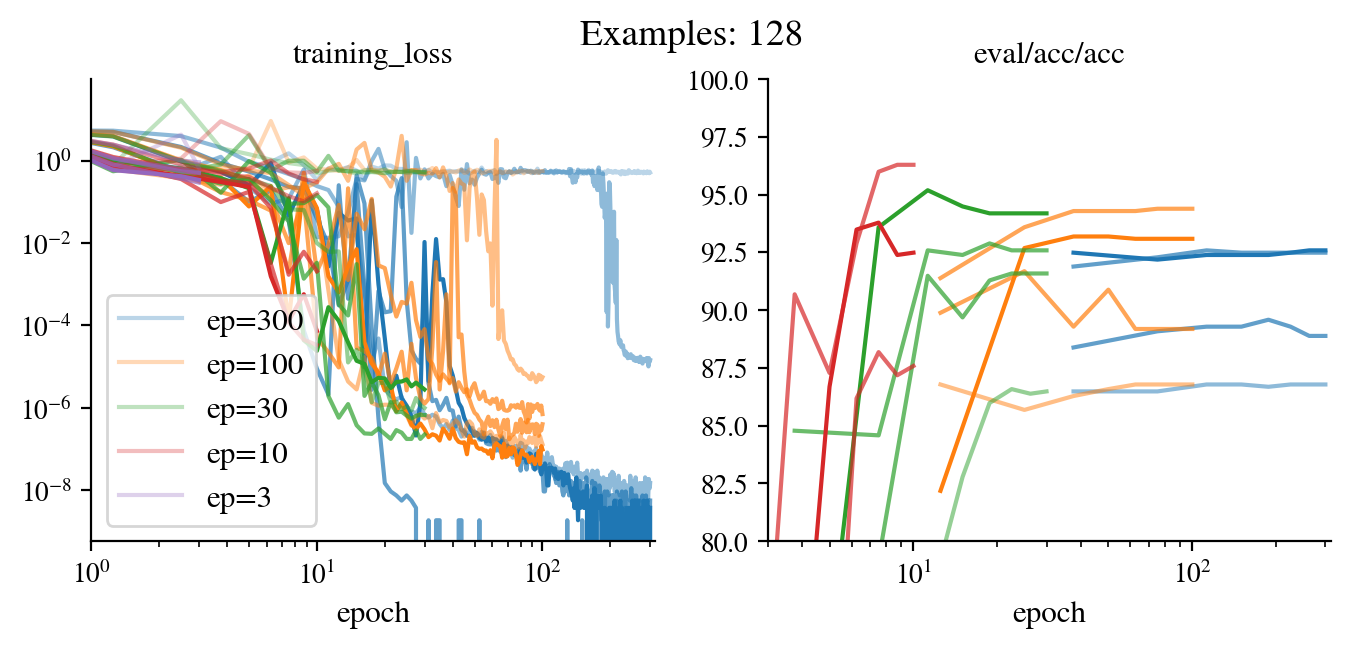

In [8]:
X = 'epoch'
Y1 = 'training_loss'
Y2 = 'eval/acc/acc'

with mpl.rc_context({'axes.spines.right': False, 'axes.spines.top': False, **latex_context(0.7)}):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
  for c, ep in zip(['C0', 'C1', 'C2', 'C3', 'C4'], reversed(eps)):
    # for lw, lr in zip([0.5, 1.0, 1.5, 3.0, 1.5, 0.5], lrs):
    for a, lr in zip([0.3, 0.5, 0.7, 1.0, 0.7, 0.5], lrs):
      ax1.plot(*xy(read_metrics(ex=128, lr=lr, ep=ep), x=X, y=Y1), c=c, alpha=a, lw=1.5, label=f'ep={ep}' if lr == lrs[0] else None)
      ax2.plot(*xy(read_metrics(ex=128, lr=lr, ep=ep), x=X, y=Y2, ymul=100), c=c, alpha=a, lw=1.5, label=f'ep={ep}' if lr == lrs[0] else None)
  ax1.legend()
  ax1.set_yscale('log') ; ax2.set_ylim(80, 100)
  ax1.set_xlim(1, None) ; ax2.set_xlim(3, None)
  ax1.set_xscale('log') ; ax2.set_xscale('log')
  ax1.set_xlabel(X) ; ax2.set_xlabel(X)
  ax1.set_title(Y1) ; ax2.set_title(Y2)
  fig.suptitle('Examples: 128');

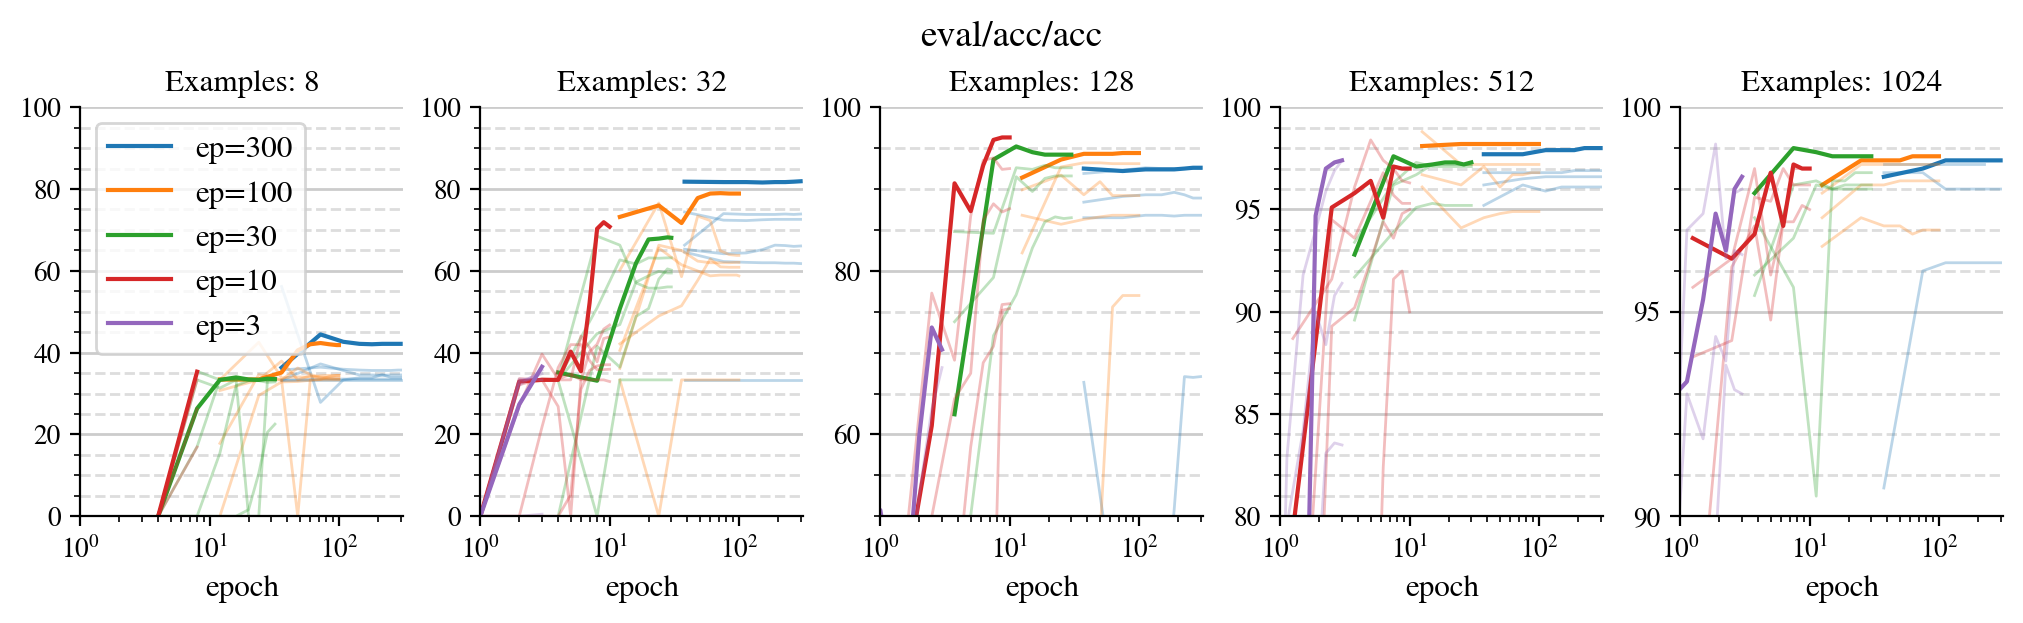

In [32]:
X = 'epoch'
Y = 'eval/acc/acc'

with mpl.rc_context({'axes.spines.right': False, 'axes.spines.top': False, **latex_context(0.7)}):
  fig, axes = plt.subplots(1, len(exs), figsize=(2*len(exs), 3), sharey=False, constrained_layout=True)
  for ax, ex in zip(axes, exs):
    ax.set_title(f'Examples: {ex}')
    for c, ep in zip(['C0', 'C1', 'C2', 'C3', 'C4'], reversed(eps)):
      best_lr = finals.sel(ex=ex, ep=ep).idxmax('lr').item()
      for lr in lrs:
        try:
          kw = dict(alpha=1.0, lw=1.5) if lr == best_lr else dict(alpha=0.3, lw=1)
          ax.plot(*xy(read_metrics(ex=ex, lr=lr, ep=ep), x=X, y=Y, ymul=100), c=c, **kw,
                  label=f'ep={ep}' if lr == best_lr else None)
        except FileNotFoundError:
          pass
    # ax.legend(loc='lower center')
  
  axes[0].legend(ncol=1)
  for ax in axes:
    ax.set_ylim(0, 100)
    ax.set_xlim(1, None)
    ax.set_xscale('log')
    ax.set_xlabel(X)
  make_hgrid(axes[0], ylim=(0, 100), major=range(0, 101, 20), minor=range(0, 101, 5))
  make_hgrid(axes[1], ylim=(0, 100), major=range(0, 101, 20), minor=range(0, 101, 5))
  make_hgrid(axes[2], ylim=(50, 100), major=range(0, 101, 20), minor=range(0, 101, 5))
  make_hgrid(axes[3], ylim=(80, 100), major=range(0, 101, 5), minor=range(0, 101, 1))
  make_hgrid(axes[4], ylim=(90, 100), major=range(0, 101, 5), minor=range(0, 101, 1))
  fig.suptitle(Y);

In [36]:
lr = finals.sel(ex=1024, ep=30).idxmax('lr').item()
preds = json.load(open(f'workdirs/workdir_ex{1024}_lr{lr}_ep{30}_11-20_2338/vqa_eval_0.json'))

In [39]:
wrongs = [p for p in preds if p['answer'] not in p['gts']]
print(len(wrongs))
wrongs

12


[{'question_id': '160', 'answer': '1', 'gts': ['2']},
 {'question_id': '165', 'answer': '2', 'gts': ['1']},
 {'question_id': '194', 'answer': '1', 'gts': ['2']},
 {'question_id': '246', 'answer': '2', 'gts': ['1']},
 {'question_id': '293', 'answer': '0', 'gts': ['1']},
 {'question_id': '294', 'answer': '1', 'gts': ['2']},
 {'question_id': '297', 'answer': '2', 'gts': ['1']},
 {'question_id': '518', 'answer': '1', 'gts': ['2']},
 {'question_id': '651', 'answer': '1', 'gts': ['2']},
 {'question_id': '707', 'answer': '1', 'gts': ['0']},
 {'question_id': '783', 'answer': '1', 'gts': ['2']},
 {'question_id': '993', 'answer': '1', 'gts': ['2']}]

In [44]:
qid2img = [json.loads(line)["image"] for line in open('workdirs/lines_data/val.jsonl')]

'val_2_037.png'

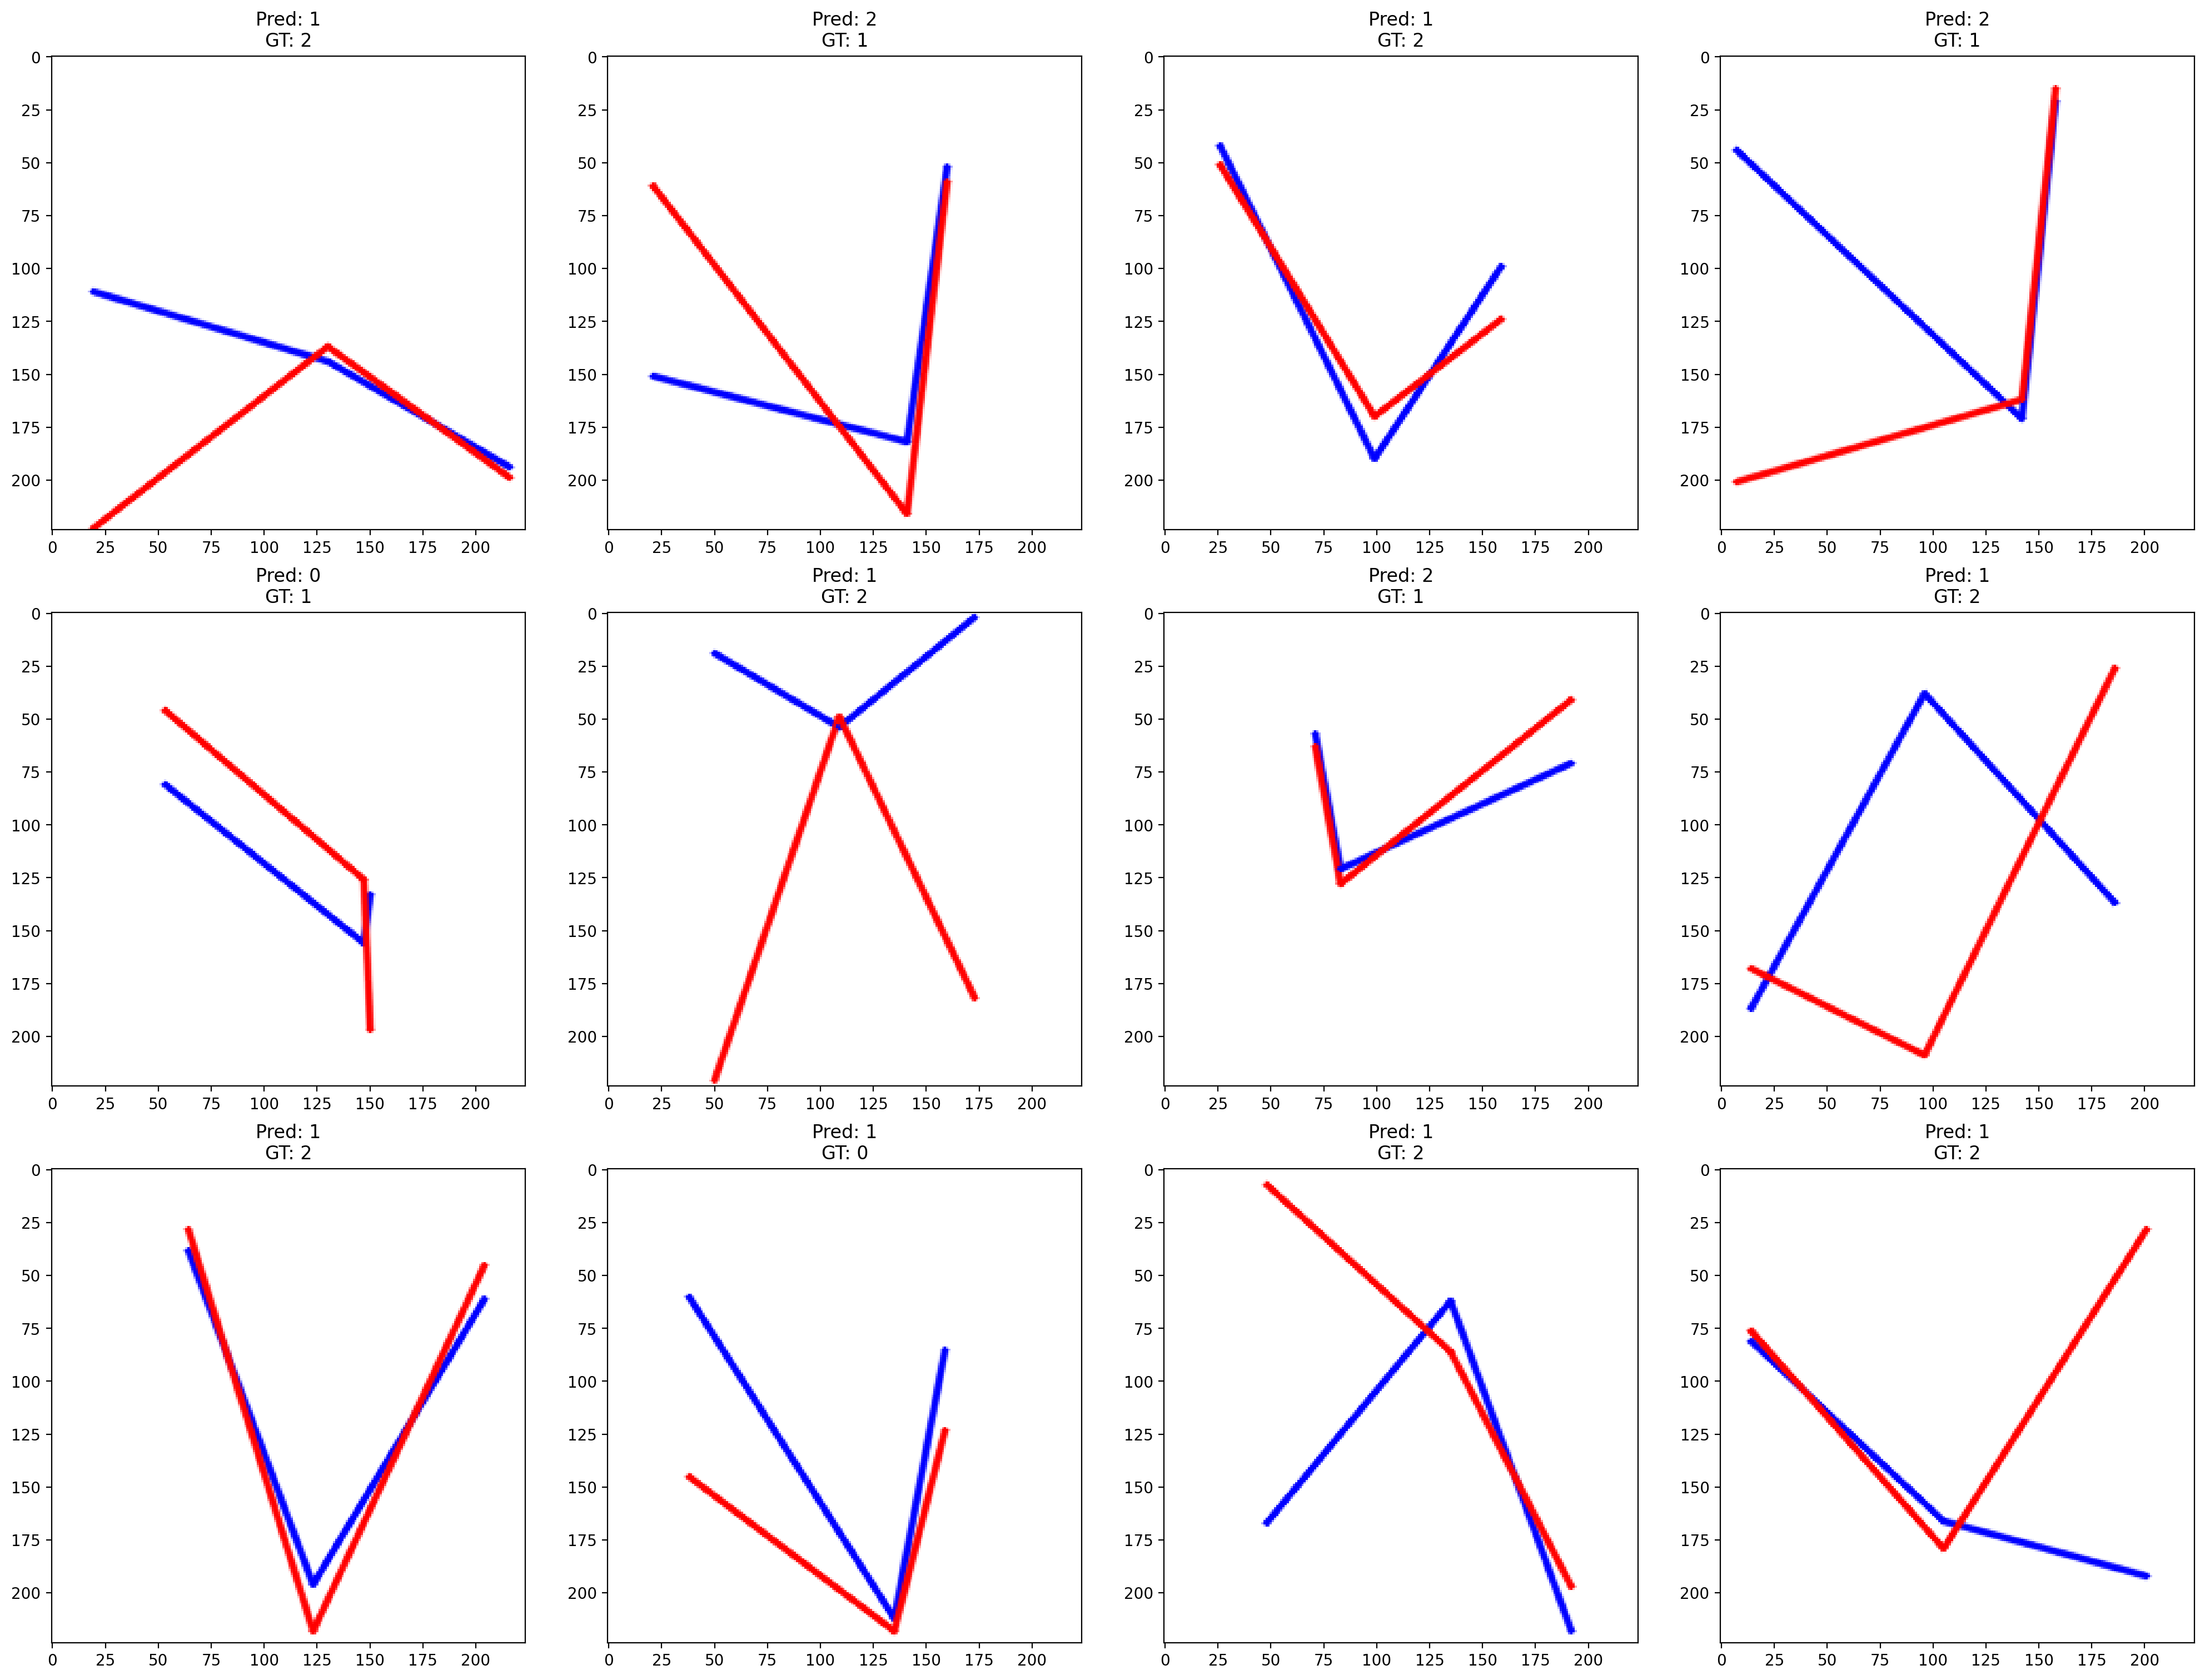

In [47]:
fig, axes = plt.subplots(3, 4, figsize=(20, 15), constrained_layout=True)
for ax, w in zip(axes.flat, wrongs):
  ax.imshow(plt.imread('workdirs/lines_data/' + qid2img[int(w['question_id'])]))
  ax.set_title(f'Pred: {w["answer"]}\nGT: {w["gts"][0]}')

# Large sweep on very low data

In [3]:
exs = [8, 32]
bss = [2, 4, 8, 16, 32]
lrs = ["3e-4", "1e-4", "3e-5", "1e-5", "3e-6", "1e-6"]
lss = ["0.0"]
dos = ["0.0", "0.1", "0.2"]
eps = [3, 10, 30, 100, 300]

In [61]:
def read_metrics(ex, bs, lr, ls, do, ep):
  return read_jsonl(f"workdirs/workdir_sweep2_ex{ex}_bs{bs}_lr{lr}_ls{ls}_do{do}_ep{ep}_11-22_1052/big_vision_metrics.txt")

In [62]:
def get_final(y):
  nans = np.full((len(exs), len(bss), len(lrs), len(lss), len(dos), len(eps)), np.nan)
  vals = xr.DataArray(nans, dims=("ex", "bs", "lr", "ls", "do", "ep"), coords={"ex": exs, "bs": bss, "lr": lrs, "ls": lss, "do": dos, "ep": eps})

  kw = {}
  for kw["ex"] in exs:
    for kw["bs"] in bss:
      for kw["lr"] in lrs:
        for kw["ls"] in lss:
          for kw["do"] in dos:
            for kw["ep"] in eps:
              print(f"\rReading: {kw}", end="", flush=True)
              x_, y_ = xy(read_metrics(**kw), x='step', y=y)
              vals.loc[kw] = y_[-1]
  return vals

ms = read_metrics(ex=8, bs=8, lr="1e-5", ls="0.0", do="0.2", ep=300)
finals = get_final("eval/acc/acc")

Reading: {'ex': 32, 'bs': 2, 'lr': '1e-6', 'ls': '0.0', 'do': '0.0', 'ep': 300}WARNING: Some steps might be missing because there was corruption on line 1199 of file workdirs/workdir_sweep2_ex32_bs2_lr1e-6_ls0.0_do0.0_ep300_11-22_1052/big_vision_metrics.txt
Reading: {'ex': 32, 'bs': 2, 'lr': '1e-6', 'ls': '0.0', 'do': '0.1', 'ep': 300}WARNING: Some steps might be missing because there was corruption on line 2601 of file workdirs/workdir_sweep2_ex32_bs2_lr1e-6_ls0.0_do0.1_ep300_11-22_1052/big_vision_metrics.txt
Reading: {'ex': 32, 'bs': 2, 'lr': '1e-6', 'ls': '0.0', 'do': '0.2', 'ep': 300}WARNING: Some steps might be missing because there was corruption on line 3422 of file workdirs/workdir_sweep2_ex32_bs2_lr1e-6_ls0.0_do0.2_ep300_11-22_1052/big_vision_metrics.txt
Reading: {'ex': 32, 'bs': 4, 'lr': '1e-6', 'ls': '0.0', 'do': '0.1', 'ep': 30}}WARNING: Some steps might be missing because there was corruption on line 209 of file workdirs/workdir_sweep2_ex32_bs4_lr1e-6_ls0.0_do0.1_ep30_11-2

In [79]:
def idxmax(x):
  return {k: x.indexes[k][v.item()] for k, v in x.argmax(...).items()}

idxmax(finals.sel(ex=8, ep=300))

{'bs': np.int64(4), 'lr': '1e-5', 'ls': '0.0', 'do': '0.0'}

In [117]:
import itertools

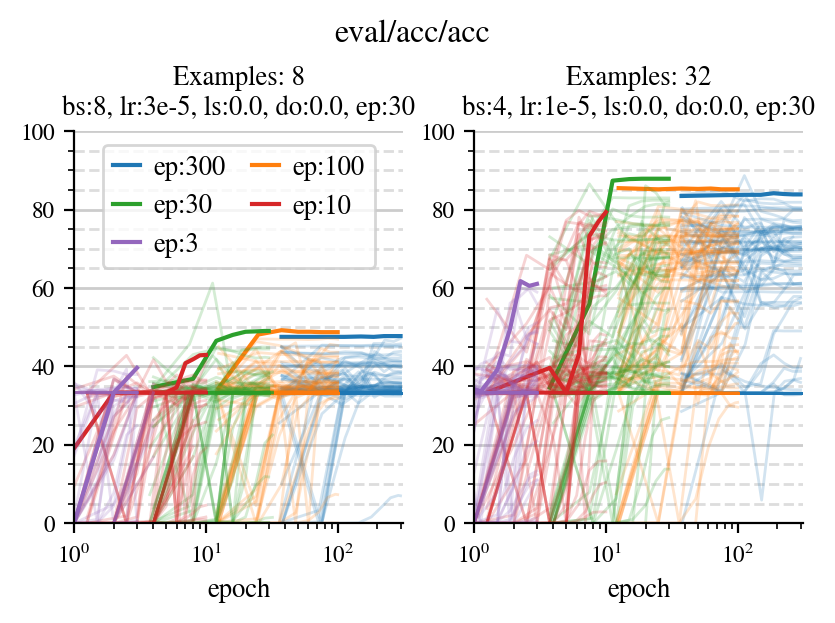

In [118]:
X = 'epoch'
Y = 'eval/acc/acc'

with mpl.rc_context({'axes.spines.right': False, 'axes.spines.top': False, **latex_context(0.6)}):
  fig, axes = plt.subplots(1, len(exs), figsize=(2*len(exs), 3), sharey=False, constrained_layout=True)
  for ax, ex in zip(axes, exs):
    ex_best = idxmax(finals.sel(ex=ex))
    ax.set_title(f'Examples: {ex}\n' + ', '.join(f"{k}:{v}" for k, v in ex_best.items()))
    for c, ep in zip(['C0', 'C1', 'C2', 'C3', 'C4'], reversed(eps)):
      best = idxmax(finals.sel(ex=ex, ep=ep))
      for bs, lr, ls, do in itertools.product(bss, lrs, lss, dos):
        kw = dict(bs=bs, lr=lr, ls=ls, do=do)
        try:
          is_best = all(kw[k] == best[k] for k in best)
          line_kw = dict(alpha=1.0, lw=1.5) if is_best else dict(alpha=0.2, lw=1)
          ax.plot(*xy(read_metrics(ex=ex, ep=ep, **kw), x=X, y=Y, ymul=100), c=c, **line_kw, label=f'ep:{ep}' if is_best else None)
        except FileNotFoundError:
          pass
  
  def flip(items, ncol=2):
      return itertools.chain(*[items[i::ncol] for i in range(ncol)])
  handles, labels = axes[0].get_legend_handles_labels()
  axes[0].legend(flip(handles), flip(labels), loc='upper center', ncol=2, handlelength=1, handletextpad=0.5, columnspacing=1)

  for ax in axes:
    make_hgrid(ax, ylim=(0, 100), major=range(0, 101, 20), minor=range(0, 101, 5))
    ax.set_xlim(1, None)
    ax.set_xscale('log')
    ax.set_xlabel(X)
  fig.suptitle(Y);